In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import os
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import griddata
from pearlsim.ml_utilities import *
from pearlsim.results_processing import read_core_flux
import pickle
from sklearn.neighbors import KNeighborsRegressor

In [13]:
all_features = pd.read_csv("training_data/current_data.csv", index_col=0)
all_targets = pd.read_csv("training_data/current_target.csv", index_col=0)

In [14]:
display(all_features.iloc[-10:])

,radius,height,cs137,xe135,u235,binR1Z1E1,binR2Z1E1,binR3Z1E1,binR4Z1E1,binR1Z2E1,...,E10_flux_interpolated,E11_flux_interpolated,E12_flux_interpolated,E13_flux_interpolated,E14_flux_interpolated,E15_flux_interpolated,E16_flux_interpolated,E17_flux_interpolated,E18_flux_interpolated,step
43990,110.1,106.9,0.000012,5.261719e-08,0.004223,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.052473e+17,4.705621e+16,2.060478e+15,4.492476e+14,7.812378e+13,1.021501e+13,5.721652e+12,2.412326e+12,1.703653e+11,350
43991,95.3,254.7,0.000060,3.036577e-08,0.002478,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,1.563066e+18,3.600443e+17,1.578506e+16,3.416926e+15,5.909821e+14,7.698267e+13,4.278871e+13,1.804434e+13,1.266103e+12,350
43992,58.5,160.3,0.000113,6.353167e-09,0.000485,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,6.641556e+17,1.510509e+17,6.403197e+15,1.351288e+15,2.279413e+14,2.885808e+13,1.590906e+13,6.638108e+12,4.596243e+11,350
43993,42.7,307.2,0.000122,1.673538e-09,0.000134,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,3.135533e+18,7.243020e+17,3.165046e+16,6.793118e+15,1.162288e+15,1.491311e+14,8.254997e+13,3.464217e+13,2.410071e+12,350
43994,66.0,329.0,0.000105,9.489247e-09,0.000799,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.626547e+18,6.096589e+17,2.690911e+16,5.824456e+15,1.001376e+15,1.282767e+14,7.125570e+13,2.988247e+13,2.082800e+12,350
43995,58.5,179.1,0.000050,3.667876e-08,0.002811,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,8.761358e+17,1.994917e+17,8.475642e+15,1.787767e+15,3.019222e+14,3.825242e+13,2.106329e+13,8.803311e+12,6.101239e+11,350
43996,75.4,89.3,0.000124,4.168309e-10,0.000035,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.056208e+17,4.697352e+16,2.021113e+15,4.305961e+14,7.349623e+13,9.426729e+12,5.216922e+12,2.175545e+12,1.513777e+11,350
43997,52.2,324.3,0.000122,1.583272e-09,0.000130,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.960803e+18,6.868043e+17,3.025790e+16,6.532861e+15,1.121866e+15,1.442922e+14,7.997620e+13,3.359659e+13,2.340820e+12,350
43998,114.4,124.6,0.000084,1.951481e-08,0.001557,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.613954e+17,5.985670e+16,2.619845e+15,5.705248e+14,9.917943e+13,1.295472e+13,7.248513e+12,3.061757e+12,2.157023e+11,350
43999,91.1,167.0,0.000124,2.134337e-10,0.000013,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,5.916431e+17,1.355528e+17,5.851130e+15,1.256172e+15,2.155663e+14,2.778512e+13,1.543509e+13,6.485590e+12,4.532945e+11,350


In [15]:
display(all_targets.iloc[-10:])

,current_E1,current_E2,current_E3,current_E4,current_E5,current_E6,current_E7,current_E8,current_E9,current_E10,current_E11,current_E12,current_E13,current_E14,current_E15,current_E16,current_E17,current_E18,power
43990,1.510090e+15,3.155310e+15,3.142170e+15,1.488560e+15,2.628330e+14,1.012190e+14,2.002370e+14,3.113200e+14,3.077750e+14,2.144950e+14,9.982240e+14,2.076240e+15,2.925720e+14,1.550610e+15,7.757660e+14,3.701630e+14,6.373380e+14,2.594780e+14,8548.3300
43991,7.004820e+14,1.432800e+15,1.379380e+15,6.548950e+14,1.186060e+14,3.608970e+13,9.184880e+13,1.343770e+14,1.447280e+14,9.877240e+13,4.589710e+14,7.163850e+14,9.930930e+13,5.836970e+14,2.671830e+14,1.484440e+14,2.324380e+14,6.000310e+13,3003.8100
43992,1.923670e+15,4.202140e+15,4.161010e+15,2.263050e+15,3.255300e+14,9.591520e+13,3.098450e+14,4.822210e+14,5.870550e+14,3.186340e+14,1.664140e+15,2.849900e+15,3.897030e+14,2.008150e+15,8.411170e+14,4.276740e+14,7.428690e+14,2.472310e+14,1620.0400
43993,4.792750e+14,1.068760e+15,1.021960e+15,4.186300e+14,5.560710e+13,2.070310e+13,5.155550e+13,7.681920e+13,9.746140e+13,3.271040e+13,2.666880e+14,3.934770e+14,4.859310e+13,2.357290e+14,9.913170e+13,3.814600e+13,9.143140e+13,4.149580e+13,123.5690
43994,3.406040e+14,7.291750e+14,6.900880e+14,3.061460e+14,3.579260e+13,1.232460e+13,3.605420e+13,5.192780e+13,6.520600e+13,3.237110e+13,1.719250e+14,2.977930e+14,4.203250e+13,1.842580e+14,9.600910e+13,4.258290e+13,8.365360e+13,2.381940e+13,310.5150
43995,1.612400e+15,3.833830e+15,3.608670e+15,1.852630e+15,3.063580e+14,7.938810e+13,2.693710e+14,3.342130e+14,4.339780e+14,2.524770e+14,1.185790e+15,2.361930e+15,3.239130e+14,1.526050e+15,8.136170e+14,3.487110e+14,6.467360e+14,2.320140e+14,7872.6700
43996,1.574190e+15,3.510330e+15,3.531940e+15,1.745730e+15,3.548930e+14,9.333640e+13,2.727840e+14,4.071240e+14,4.770560e+14,2.985580e+14,1.387620e+15,2.782090e+15,4.493270e+14,1.996390e+15,1.006660e+15,4.347560e+14,7.474500e+14,3.048320e+14,101.2900
43997,3.302340e+14,8.090940e+14,8.247460e+14,3.493140e+14,3.249070e+13,1.541190e+13,2.879100e+13,5.518250e+13,7.422030e+13,3.471460e+13,1.522600e+14,2.814420e+14,3.797200e+13,1.937700e+14,1.054080e+14,3.249750e+13,6.249970e+13,1.898940e+13,68.5903
43998,1.310400e+15,2.987010e+15,2.903520e+15,1.393020e+15,1.553830e+14,6.070740e+13,1.662380e+14,2.405380e+14,2.561350e+14,1.736680e+14,7.692230e+14,1.380810e+15,1.847360e+14,9.453930e+14,4.614180e+14,2.624660e+14,4.620700e+14,1.764480e+14,3354.6100
43999,1.453990e+15,3.275280e+15,3.075710e+15,1.572020e+15,2.435610e+14,9.185030e+13,2.336300e+14,3.346200e+14,4.542010e+14,2.579080e+14,1.128880e+15,1.997660e+15,2.944750e+14,1.385660e+15,6.523450e+14,3.793250e+14,6.994110e+14,2.067290e+14,37.2269


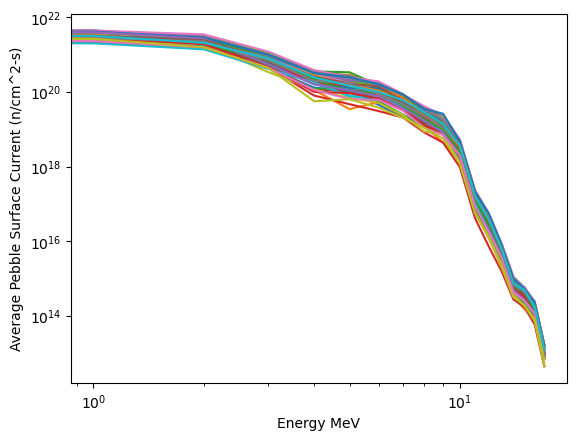

Pebble power: 1211.1


In [16]:
plt.figure()
for i_to_plot in range(50):
    energies = all_targets.drop(columns="power").columns.to_list()
    sample_current = all_targets.drop(columns="power").iloc[i_to_plot].to_list()

    # Divide by the energy bin width when plotting to better see the function
    plt.plot(energies, sample_current/np.diff(ENERGY_BINS))
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Energy MeV")
    plt.ylabel("Average Pebble Surface Current (n/cm^2-s)")
plt.show()
print(f"Pebble power: {all_targets.iloc[i_to_plot]['power']}")

# Data Standardization
Simple standardization is performed here along each column. I tried log-standardization, but it didn't seem to help with the current values.

In [19]:
# Any feature removals and substitions can happen here
features = all_features.drop(columns=["step"])
targets = all_targets

In [20]:
train_split = 0.8
np.random.seed(42)

def standardize(raw_data, mean=None, std=None, axis=0):
    if mean is None:
        mean = np.mean(raw_data, axis = axis)
    if std is None:
        std = np.std(raw_data, axis = axis)
        std[ std==0 ] = 0.1
    result = (raw_data - mean) / std
    return result, mean, std

def unstandardize(standardized_data, mean, std):
    raw_data = (standardized_data*std)+mean
    return raw_data

num_data = len(features)
training_size = int(num_data*train_split)
testing_size = num_data - training_size
data_indices = np.arange(num_data)
training_indices = np.random.choice(num_data, training_size, replace=False)
testing_indices = data_indices[np.in1d(data_indices, training_indices, invert=True)]

training_data, data_mean, data_std = standardize(features.iloc[training_indices])
training_target, target_mean, target_std = standardize(targets.iloc[training_indices])
testing_data, _, _  = standardize(features.iloc[testing_indices], mean=data_mean, std=data_std)
testing_target, _, _  = standardize(targets.iloc[testing_indices], mean=target_mean, std=target_std)

print(np.shape(training_data))
print(np.shape(training_target))
print(np.shape(testing_data))
print(np.shape(testing_target))

(35200, 743)
(35200, 19)
(8800, 743)
(8800, 19)


In [21]:
display(training_data.iloc[-5:])

,radius,height,cs137,xe135,u235,binR1Z1E1,binR2Z1E1,binR3Z1E1,binR4Z1E1,binR1Z2E1,...,E9_flux_interpolated,E10_flux_interpolated,E11_flux_interpolated,E12_flux_interpolated,E13_flux_interpolated,E14_flux_interpolated,E15_flux_interpolated,E16_flux_interpolated,E17_flux_interpolated,E18_flux_interpolated
13313,-1.577756,-1.281180,-0.355605,0.634952,0.338381,-0.759499,-0.770365,-0.776039,-0.738382,-0.859131,...,-0.145298,-0.132588,-0.114814,-0.119707,-0.140906,-0.157888,-0.174280,-0.185172,-0.191758,-0.199587
13528,-0.936230,0.583263,-1.131969,1.780443,1.132752,-0.759499,-0.770365,-0.776039,-0.738382,-0.859131,...,0.342820,0.367720,0.401108,0.414132,0.400286,0.385002,0.370189,0.362164,0.352355,0.338930
25017,0.938450,-0.458632,0.868580,-0.632403,-0.869538,1.106487,1.081092,1.027220,1.052753,0.819397,...,-0.351450,-0.359049,-0.374116,-0.378411,-0.368888,-0.353735,-0.331062,-0.324653,-0.316413,-0.299030
19317,0.824401,-1.353518,0.326040,-0.162840,-0.359117,-0.068149,-0.078895,-0.103579,-0.024886,-0.307585,...,-0.885475,-0.890075,-0.895237,-0.896025,-0.889960,-0.884603,-0.873989,-0.870766,-0.867505,-0.862658
7928,0.421665,0.673101,-1.187405,1.574875,1.189130,-1.418170,-1.431213,-1.426648,-1.439555,-1.327324,...,-0.440048,-0.422584,-0.391286,-0.357554,-0.347645,-0.342979,-0.328799,-0.330084,-0.326600,-0.319972


# Model Training
I threw together a quick RFR model and got some results. You're free to change to any other type of model, as long as its something I can save and load into other modules. Things to try:
- Properly using cross validation
- Tuning the hyper parameters
- Trying a different model, probably a neural net

In [117]:
best_params = {'max_depth': 12, 
               'n_estimators': 1000, 
               'n_jobs': 24,} # Set to your number of cores
rfr_model = RandomForestRegressor(random_state=0)
rfr_model.set_params(**best_params)
rfr_model.fit(training_data, training_target['power'])
rfr_model_test_score = rfr_model.score(testing_data, testing_target['power'])
print(f"RFR score: {rfr_model_test_score}")

RFR score: 0.9750766176876229


Next we save the models and standardization parameters so the model can be used in the simulation.

In [152]:
model_data = pickle.dumps(rfr_model)
with open("ml_models/current_rfr.pkl", 'wb') as f:
    f.write(model_data)
data_mean.to_csv("ml_models/current_rfr_data_mean.csv", header=True)
data_std.to_csv("ml_models/current_rfr_data_std.csv", header=True)
target_mean.to_csv("ml_models/current_rfr_target_mean.csv", header=True)
target_std.to_csv("ml_models/current_rfr_target_std.csv", header=True)

In [153]:
all_features.drop(columns=["radius","height"]).iloc[7*4000+1]

index          0.000000e+00
cs137          9.529456e-05
xe135          1.481146e-08
u235           1.138590e-03
binR1Z1E1      2.648924e+20
                   ...     
binR4Z9E18     1.154314e+12
binR1Z10E18    1.233549e+12
binR2Z10E18    1.158767e+12
binR3Z10E18    9.428232e+11
binR4Z10E18    6.635591e+11
Name: 28000, Length: 724, dtype: float64

In [174]:
plot_radius = np.arange(0,120,0.5)
plot_height = np.arange(60,370,0.5)
grid_radius, grid_height = np.meshgrid(plot_radius, plot_height)
num_points = len(plot_radius)*len(plot_height)
constants = all_features.drop(columns=["radius","height"]).iloc[7*4000+2]
plot_grid = pd.DataFrame({"radius":grid_radius.flatten(),"height":grid_height.flatten()})
for feature in constants.keys():
    plot_grid[feature] = constants[feature]

display(plot_grid)

,radius,height,cs137,xe135,u235,binR1Z1E1,binR2Z1E1,binR3Z1E1,binR4Z1E1,binR1Z2E1,...,binR3Z8E18,binR4Z8E18,binR1Z9E18,binR2Z9E18,binR3Z9E18,binR4Z9E18,binR1Z10E18,binR2Z10E18,binR3Z10E18,binR4Z10E18
0,0.0,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
1,0.5,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
2,1.0,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
3,1.5,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
4,2.0,60.0,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148795,117.5,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
148796,118.0,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
148797,118.5,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11
148798,119.0,369.5,0.000079,2.174626e-08,0.001735,2.648924e+20,2.435903e+20,2.092314e+20,1.741044e+20,3.646944e+20,...,1.611570e+12,1.195377e+12,1.986022e+12,1.840819e+12,1.578203e+12,1.154314e+12,1.233549e+12,1.158767e+12,9.428232e+11,6.635591e+11


In [175]:
std_plot_data, _, _  = standardize(plot_grid, mean=data_mean, std=data_std)
predicted_currents_stan = pd.DataFrame(rfr_model.predict(std_plot_data),columns=target_mean.keys())
predicted_currents = unstandardize(predicted_currents_stan, target_mean, target_std)
predicted_currents

,2.9005e-08,9.9e-08,2.1e-07,4.525e-07,7.985000000000001e-07,1.061e-06,1.5025e-06,2.9275e-06,6.9385e-06,1.29225e-05,8.234799999999999e-05,0.002839364,0.007324,0.060059,0.3055,0.6605,1.5259999999999998,6.1155,power
0,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
1,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
2,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
3,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
4,1.263647e+15,2.871676e+15,2.869039e+15,1.439584e+15,2.681861e+14,7.987940e+13,2.248350e+14,3.422306e+14,4.123560e+14,2.242552e+14,1.140145e+15,1.989796e+15,2.849299e+14,1.448902e+15,6.571449e+14,3.117875e+14,5.585981e+14,2.099302e+14,4378.375474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148795,1.771917e+14,3.917056e+14,3.727134e+14,1.639614e+14,1.531825e+13,4.140286e+12,1.428259e+13,1.945208e+13,2.211608e+13,1.541826e+13,5.678626e+13,9.852049e+13,1.730570e+13,7.391276e+13,4.587064e+13,1.586934e+13,3.425345e+13,1.370645e+13,478.290418
148796,1.775746e+14,3.926674e+14,3.742234e+14,1.634098e+14,1.530601e+13,4.018922e+12,1.392963e+13,1.919819e+13,2.181399e+13,1.581806e+13,5.641773e+13,9.790659e+13,1.649141e+13,7.332398e+13,4.505300e+13,1.577722e+13,3.352279e+13,1.342556e+13,508.681753
148797,1.775746e+14,3.926674e+14,3.742234e+14,1.634098e+14,1.530601e+13,4.018922e+12,1.392963e+13,1.919819e+13,2.181399e+13,1.581806e+13,5.641773e+13,9.790659e+13,1.649141e+13,7.332398e+13,4.505300e+13,1.577722e+13,3.352279e+13,1.342556e+13,508.681753
148798,1.775746e+14,3.926674e+14,3.742234e+14,1.634098e+14,1.530601e+13,4.018922e+12,1.392963e+13,1.919819e+13,2.181399e+13,1.581806e+13,5.641773e+13,9.790659e+13,1.649141e+13,7.332398e+13,4.505300e+13,1.577722e+13,3.352279e+13,1.342556e+13,508.681753


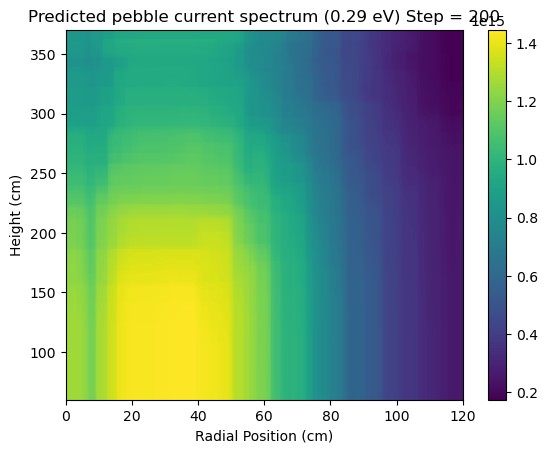

In [177]:
plot_target = predicted_currents[2.9005e-08].to_numpy().reshape(len(plot_height), len(plot_radius))
plt.imshow(np.rot90(plot_target,1), extent=(0,120,60,370), aspect='auto')
plt.title(f"Predicted pebble current spectrum (0.29 eV) Step = 200")
plt.xlabel("Radial Position (cm)")
plt.ylabel("Height (cm)")
plt.colorbar()

In [178]:
core_flux,_ = read_core_flux("gFHR_equilibrium/gFHR_equilibrium_200.serpent_det0.m", normalize_and_label=True)

[75.5, 75.5, 75.5, 75.5, 106.5, 106.5, 106.5, 106.5, 137.5, 137.5, 137.5, 137.5, 168.5, 168.5, 168.5, 168.5, 199.5, 199.5, 199.5, 199.5, 230.5, 230.5, 230.5, 230.5, 261.5, 261.5, 261.5, 261.5, 292.5, 292.5, 292.5, 292.5, 323.5, 323.5, 323.5, 323.5, 354.5, 354.5, 354.5, 354.5]


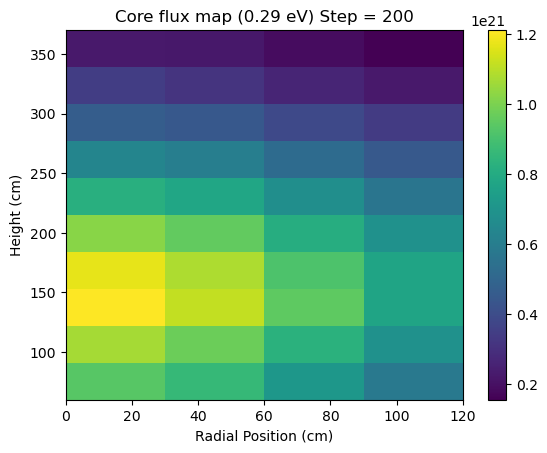

In [181]:
radius_vals = []
height_vals = []
flux_vals = []
radius_bounds = np.linspace(0,120,5)
height_bounds = np.linspace(60,370,11)
desired_E = 3
for column in core_flux.columns:
    R = int(column.split("R")[1].split("Z")[0])
    Z = int(column.split("Z")[1].split("E")[0])
    E = int(column.split("E")[1])
    if E == desired_E:
        radius_vals += [ (radius_bounds[R]+radius_bounds[R-1])/2 ]
        height_vals += [ (height_bounds[Z]+height_bounds[Z-1])/2]
        flux_vals += [core_flux[column].iloc[0]]

serpent_flux = np.array(flux_vals).reshape(10,4)
#plt.imshow(serpent_flux)
print(height_vals)

plt.imshow(serpent_flux, extent=(0,120,60,370), aspect='auto')
plt.title(f"Core flux map (0.29 eV) Step = 200")
plt.xlabel("Radial Position (cm)")
plt.ylabel("Height (cm)")
plt.colorbar()

In [33]:
constants.loc[constants.index.repeat(1)].reset_index(drop=True)

0      0.000000e+00
1      0.000000e+00
2      4.669530e-03
3      1.013601e+20
4      9.413196e+19
           ...     
718    3.919154e+11
719    3.673934e+11
720    3.373850e+11
721    2.810195e+11
722    2.163722e+11
Name: 0, Length: 723, dtype: float64

In [24]:
constants

,0
cs137,0.000000e+00
xe135,0.000000e+00
u235,4.669530e-03
binR1Z1E1,1.013601e+20
binR2Z1E1,9.413196e+19
...,...
binR4Z9E18,3.919154e+11
binR1Z10E18,3.673934e+11
binR2Z10E18,3.373850e+11
binR3Z10E18,2.810195e+11
